# Price Prediction, Anomaly Detection & Clustering

Dataset: kolesa_ml_ready.csv

In [1]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.cluster import KMeans

from catboost import CatBoostRegressor
import shap
import matplotlib.pyplot as plt


In [2]:

df = pd.read_csv('../data/processed/kolesa_cleaned.csv')
df.head()


,title,price,description,city,views,url,year,mileage,engine_l,fuel,gearbox,car_age,price_per_year,price_per_km,price_z
0,OMODA S5 Luxury,8490000.0,"2025 г., новый седан, 1.5 л, бензин, КПП вариа...",Кызылорда,0,https://kolesa.kz/a/show/204119183?search_id=2...,2025.0,NaN,1.5,petrol,cvt,0.0,inf,NaN,-0.270320
1,Toyota Camry,14200000.0,"2018 г., Б/у седан, 2.5 л, бензин, КПП автомат...",Астана,0,https://kolesa.kz/a/show/207464221?search_id=2...,2018.0,121000.0,2.5,petrol,automatic,7.0,2.028571e+06,117.355372,0.075199
2,Jaecoo J8 Comfort,14990000.0,"2025 г., новый кроссовер, 2 л, бензин, КПП робот",Алматы,0,https://kolesa.kz/a/show/180677062?search_id=2...,2025.0,NaN,2.0,petrol,other,0.0,inf,NaN,0.123003
3,ВАЗ (Lada) 2112,700000.0,"2004 г., Б/у хэтчбек, 1.6 л, бензин, КПП механ...",Астана,0,https://kolesa.kz/a/show/207465060?search_id=2...,2004.0,250000.0,1.6,petrol,manual,21.0,3.333333e+04,2.800000,-0.741703
4,Toyota Land Cruiser Prado,24900000.0,"2018 г., Б/у внедорожник, 2.7 л, бензин, КПП а...",Алматы,0,https://kolesa.kz/a/show/207436109?search_id=2...,2018.0,67780.0,2.7,petrol,automatic,7.0,3.557143e+06,367.365004,0.722670


In [3]:

# Check data types and non-numeric columns
print("Data shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nNon-numeric columns:")
non_numeric = df.select_dtypes(include=['object']).columns.tolist()
print(non_numeric)


Data shape: (9300, 15)

Data types:
title              object
price             float64
description        object
city               object
views               int64
url                object
year              float64
mileage           float64
engine_l          float64
fuel               object
gearbox            object
car_age           float64
price_per_year    float64
price_per_km      float64
price_z           float64
dtype: object

Non-numeric columns:
['title', 'description', 'city', 'url', 'fuel', 'gearbox']


## Feature Engineering

In [4]:

# Drop columns that shouldn't be used for modeling
df = df.drop(['title', 'description', 'url'], axis=1)

df['mileage'] = df['mileage'].fillna(df['mileage'].median())
df['engine_l'] = df['engine_l'].fillna(df['engine_l'].median())

df['mileage_per_year'] = df['mileage'] / df['car_age'].replace(0,1)

city_price = df.groupby('city')['price'].mean()
df['city_price_index'] = df['city'].map(city_price)

df['price_per_km'] = df['price'] / df['mileage'].replace(0,1)


In [5]:
df['price_per_year'] = df['price'] / df['car_age'].replace(0, 1)


## Encoding

In [6]:

for col in ['fuel','gearbox','city']:
    df[col] = LabelEncoder().fit_transform(df[col])


## Price Prediction

In [8]:

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [9]:

# Check for infinity and NaN values
print("Infinity values:")
print((np.isinf(df)).sum())
print("\nNaN values:")
print(df.isna().sum())

# Replace infinity with NaN and then fill with median
df = df.replace([np.inf, -np.inf], np.nan)
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isna().any():
        df[col].fillna(df[col].median(), inplace=True)


Infinity values:
price               0
city                0
views               0
year                0
mileage             0
engine_l            0
fuel                0
gearbox             0
car_age             0
price_per_year      0
price_per_km        0
price_z             0
mileage_per_year    0
city_price_index    0
dtype: int64

NaN values:
price               0
city                0
views               0
year                0
mileage             0
engine_l            0
fuel                0
gearbox             0
car_age             0
price_per_year      0
price_per_km        0
price_z             0
mileage_per_year    0
city_price_index    0
dtype: int64


In [11]:

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
rmse = mean_squared_error(y_test, pred) ** 0.5
print("RMSE:", rmse)
print("RF R2:", r2_score(y_test, pred))


RMSE: 222245.84641115795
RF R2: 0.9998319604828878


In [12]:

cat = CatBoostRegressor(iterations=300, learning_rate=0.1, depth=8, verbose=False)
cat.fit(X_train, y_train)

pred = cat.predict(X_test)
rmse = mean_squared_error(y_test, pred) ** 0.5
print("CatBoost RMSE:", rmse)
print("CatBoost R2:", r2_score(y_test, pred))


CatBoost RMSE: 2086285.5691295865
CatBoost R2: 0.985192162948231


## SHAP Interpretation

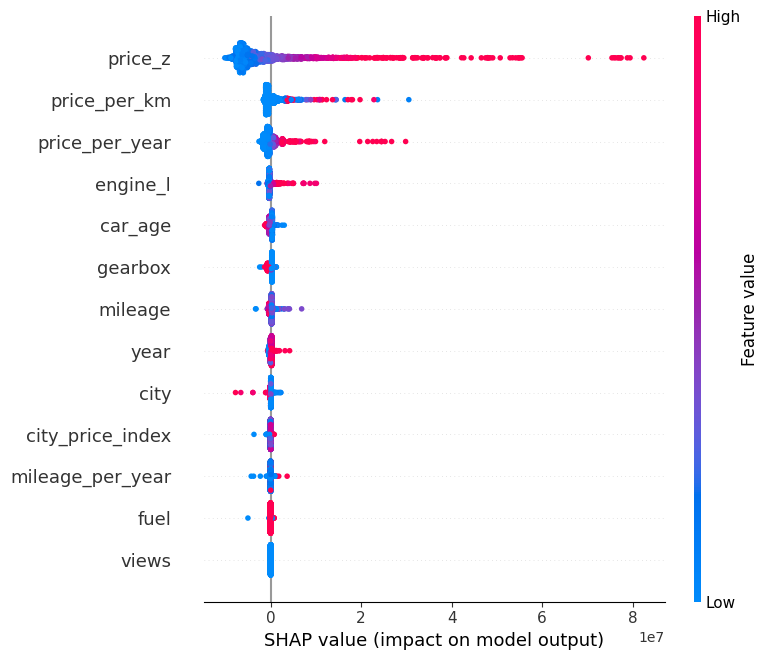

In [13]:

explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


## Anomaly Detection

In [14]:

iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(X)

df['z_price'] = (df['price'] - df['price'].mean()) / df['price'].std()
df[df['anomaly'] == -1].head()


,price,city,views,year,mileage,engine_l,fuel,gearbox,car_age,price_per_year,price_per_km,price_z,mileage_per_year,city_price_index,anomaly,z_price
37,128000000.0,16,0,2022.0,24954.0,4.0,4,0,3.0,4.266667e+07,5.129438e+03,6.961384,8318.000000,1.856530e+07,-1,6.961009
41,128000000.0,16,0,2022.0,24954.0,4.0,4,0,3.0,4.266667e+07,5.129438e+03,6.961384,8318.000000,1.856530e+07,-1,6.961009
46,38533437.0,71,0,2025.0,5.0,2.0,3,0,0.0,3.853344e+07,7.706687e+06,1.547647,5.000000,1.228936e+07,-1,1.547563
73,25200000.0,122,0,2025.0,1700.0,2.5,3,1,0.0,2.520000e+07,1.482353e+04,0.740823,1700.000000,1.184422e+07,-1,0.740783
75,37000000.0,16,0,2022.0,17000.0,3.0,0,0,3.0,1.233333e+07,2.176471e+03,1.454856,5666.666667,1.856530e+07,-1,1.454778


## Z-Score

## Clustering

In [16]:
from scipy.stats import zscore

df['price_z'] = zscore(df['price'])

overpriced_z = df[df['price_z'] > 2]

overpriced_z[['price', 'year', 'mileage', 'city', 'price_z']].head()


,price,year,mileage,city,price_z
37,128000000.0,2022.0,24954.0,16,6.961384
41,128000000.0,2022.0,24954.0,16,6.961384
44,60000000.0,2022.0,60000.0,10,2.846616
80,92000000.0,2024.0,1200.0,16,4.782977
128,87390000.0,2025.0,135078.0,19,4.504020


In [15]:

cluster_features = df[['price','car_age','mileage','engine_l']]

kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_features)

df.groupby('cluster')[['price','car_age','mileage']].mean()


,price,car_age,mileage
cluster,,,
0,6.774016e+06,13.163623,167303.513942
1,1.468207e+08,1.422222,55722.955556
2,6.054674e+07,1.745098,66766.801471
3,2.319541e+07,3.511223,96229.533670


## Clustering — DBSCAN

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

dbscan_features = df[['price', 'car_age', 'mileage', 'engine_l']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(dbscan_features)

dbscan = DBSCAN(eps=0.8, min_samples=10)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

df['dbscan_cluster'].value_counts()


dbscan_cluster
 0    9194
-1     106
Name: count, dtype: int64